<a href="https://colab.research.google.com/github/wsbiii/Deep-Learning/blob/main/LangChain_Custom_Llama_3_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Building Open Source LLM Agents with Llama 3 </h1>

# Objective

- To build a Llama 3 agent with LangGraph

In [ ]:
import os

In [ ]:
os.environ['TAVILY_API_KEY']='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'
os.environ['GROQ_API_KEY']='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'


In [ ]:
# Add tracing [OPTIONAL]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"

In [ ]:
os.environ["LANGCHAIN_PROJECT"]= "llama-tool-use-agent"

In [ ]:
import langchain_community
import langchain

# Connects Tools to LLM

## Create the Tools

In [ ]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults
import replicate

@tool
def magic_function(input: int) -> int:
  """Applies a magic function to an input"""
  return input + 2

@tool
def web_search(input: str) -> str:
  """Searches the web for a query"""
  web_search_tool = TavilySearchResults()
  docs = web_search_tool.invoke({"query": input})
  return docs

os.environ["REPLICATE_API_TOKEN"] = "r8_Pn40p5uXyMuwbKlGMlAc61kmX3TZZ9s4VALwY"

@tool
def text2image(text: str) -> str:
    """Generates an image from a text prompt"""
    output = replicate.run(
        "lucataco/open-dalle-v1.1:1c7d4c8dec39c7306df7794b28419078cb9d18b9213ab1c21fdc46a1deca0144",
        input={
            "width": 1024,
            "height": 1024,
            "prompt": text, #"a yellow lab puppy running free with wild flowers in the mountain behind"
            "scheduler": "KarrasDPM",
            "num_outputs": 1,
            "guidance_scale": 7.5,
            "apply_watermark": True,
            "negative_prompt": "worst quality, low quality",
            "prompt_strength": 0.8,
            "num_inference_steps": 60
        }
    )
    print(output)
    return output[0]
# lucataco/open-dalle-v1.1:1c7d4c8dec39c7306df7794b28419078cb9d18b9213ab1c21fdc46a1deca0144
# stability-ai/sdxl:39ed52f2a78e934b3ba6e2a89f5b1c712de7dfea535525255b1aa35c5565e08b
@tool
def image2text(image_url: str, prompt: str) -> str:
    """Generates a text description of an image"""
    input = {
        "image": image_url,
        "prompt": prompt
    }

    output = replicate.run(
        "yorickvp/llava-13b:b5f6212d032508382d61ff00469ddda3e32fd8a0e75dc39d8a4191bb742157fb",
        input=input
    )

    return "".join(output)

@tool
def text2speech(text: str) -> int:
    """Generates speech from a text prompt"""
    output = replicate.run(
        "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
        input={
            "task_name": "T2ST (Text to Speech translation)",
            "input_text": text,
            "input_text_language": "English",
            "max_input_audio_length": 60,
            "target_language_text_only": "English",
            "target_language_with_speech": "English"
        }
    )
    return output['audio_output']

tools = [magic_function,
         web_search,
         text2image,
         image2text,
         text2speech]

print(magic_function)
magic_function.args_schema

name='magic_function' description='Applies a magic function to an input' args_schema=<class 'pydantic.v1.main.magic_functionSchema'> func=<function magic_function at 0x7ce964dcb370>


pydantic.v1.main.magic_functionSchema

## Create the Response

In [ ]:
from datetime import datetime
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

# Prompt
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
         "You are a helpful assistant with two tools: (1) web search,"
         "(2) a custom, magic_function. Use web search for current events and use "
         "magic_function if the question directly asks for it. Otherwise, answer directly."
         "Current time: {time}"),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

# LLM chain
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

# Test Tools

In [ ]:
question = "What is magic_function(3)"
payload = assistant_runnable.invoke({"messages": [("user", question)]})
payload.tool_calls

[{'name': 'magic_function',
  'args': {'input': 3},
  'id': 'call_dqdv',
  'type': 'tool_call'}]

In [ ]:
question = "What is the capitol of the USA?"
payload = assistant_runnable.invoke({"messages": [("user", question)]})
payload.tool_calls

[]

The tools have successfully connected but the agent has not been built nor connected to the LLM chain.

## Build the Agent

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

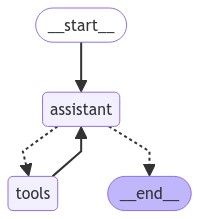

In [ ]:
from re import S
from datetime import datetime
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

# class Assistant: is wrapping assistant _runnable from the LLM chain
class Assistant:

  def __init__(self, runnable: Runnable):
    self.runnable = runnable

  def __call__(self, state: State, config: RunnableConfig):
    while True:
      # invokes the tool-calling LLM
      result = self.runnable.invoke(state)
      # if there is a tool call = valid response
      # Response with meaningful text = valid response
      # Else reprompt because not useful
      if not result.tool_calls and (
          not result.content
          or isinstance(result.content, list)
          and not result.content[0].get("text")
      ):  # Then we retry
          messages = state["messages"] + [("user", "Respond with a real output.")]
          state = {**state, "messages": messages}
      else:
          break
    return {"messages": result}

# Tool
# tool node invokes the tool
def create_tool_node_with_fallback(tools: list) -> dict:
  return ToolNode(tools).with_fallbacks(
      [RunnableLambda(handle_tool_error)], exception_key = "error"
  )

# Utilities

def _print_event(event: dict, _printed: set, max_length=1500):
  current_state = event.get("dialog_state")
  if current_state:
    print(f"Currently in:", current_state[-1])
  message = event.get("messages")
  if message:
    if isinstance(message, list):
      message = message[-1]
    if message.id not in _printed:
        msg_repr = message.pretty_repr(html=True)
        if len(msg_repr) > max_length:
            msg_repr = msg_repr[:max_length] + "... (truncated)"
        print(msg_repr)
        _printed.add(message.id)


def handle_tool_error(state) -> dict:
  error = state.get("error")
  tool_calls = state["messages"][-1].tool_calls
  return {
      "messages": [
          mboxMessage(
              content=f"Error: {repr(error)}\n please fix your mistakes.",
              tool_call_id=tc["id"],
          )
          for tc in tool_calls
      ]
  }


from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables import RunnableLambda

#Graph
builder = StateGraph(State)

#Define the nodes
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

#Define the Edges
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    {"tools": "tools", END: END},
)
builder.add_edge("tools","assistant")

memory = SqliteSaver.from_conn_string(":memory:")
with memory as memory_saver: # Use a context manager to access the SqliteSaver object
    graph = builder.compile(checkpointer=memory_saver) # Pass the SqliteSaver object to compile

from IPython.display import Image, display

try:
  display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
  pass




# Testing

In [ ]:
questions = ["What is magic_function(3)",
             "What is the weather in San Diego now?",
             "Generate an image based upon this text: 'a yellow lab puppy running free with wild flowers in the monutain behind'",
             ]
import uuid
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "thread_id": thread_id, # Checkpoints are accessed by thread_id
    }
}

events = graph.stream(
    {"messages": ("user", questions[1])}, config, stream_mode ="values"
)
for event in events:
  _print_event(event, _printed)


================================ Human Message =================================

What is the weather in San Diego now?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_20rk)
 Call ID: call_20rk
  Args:
    input: current weather in San Diego
================================= Tool Message =================================
Name: web_search

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Diego', 'region': 'California', 'country': 'United States of America', 'lat': 32.72, 'lon': -117.16, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1724262295, 'localtime': '2024-08-21 10:44'}, 'current': {'last_updated_epoch': 1724261400, 'last_updated': '2024-08-21 10:30', 'temp_c': 23.9, 'temp_f': 75.0, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 226, 'wind_dir': 'SW', 'pressu

Replicate Error 422 (details:The specified version does not exist (or perhaps you don't have permission to use it?))

Occurs when attempting to call text2image

In [ ]:
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "thread_id": thread_id, # Checkpoints are accessed by thread_id
    }
}

events = graph.stream(
    {"messages": ("user", questions[2])}, config, stream_mode ="values"
)
for event in events:
  _print_event(event, _printed)

================================ Human Message =================================

Generate an image based upon this text: 'a yellow lab puppy running free with wild flowers in the monutain behind'
================================== Ai Message ==================================
Tool Calls:
  text2image (call_df7z)
 Call ID: call_df7z
  Args:
    text: a yellow lab puppy running free with wild flowers in the mountain behind
================================= Tool Message =================================
Name: text2image

Error: ReplicateError(type=None, title='Invalid version or not permitted', status=422, detail="The specified version does not exist (or perhaps you don't have permission to use it?)", instance=None)
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  text2image (call_epdx)
 Call ID: call_epdx
  Args:
    text: a yellow lab puppy running free with wild flowers in the mountain behind
====================

# References

https://www.youtube.com/watch?v=j2OAeeujQ9M